# Calculate HI mass error
+ alfalfa 误差直接读取即可
+ HI-MaNGA 误差需要计算
> 计算HI flux误差   
> 计算HI mass误差 【若仿照alfalfa的处理方法，需要额外加入10%的误差，包含观测设备等误差】

\begin{align}
  \because F_{HI,error} &= rms\sqrt{\Delta v W} \\
  M_{HI,error} &= \frac{\sqrt{(\frac{F_{HI,error}}{F_{HI}})^2}}{ln10} \\
  \Rightarrow M_{HI,error} &= \frac{\sqrt{(\frac{rms\sqrt{\Delta v W}}{F_{HI}})^2}}{ln10} \\
\end{align}

In [10]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings
from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('onedork')#('grade3')

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [11]:
# read data
# MaNGA-HI
mgHI_fits = copy(fits.open('../../../bak_la/root/cosmos/data/mangaHIall.fits'))
# 获取 MaNGA-ALFALFA 匹配数据，源于 MaNGA-HI 论文，无效数据为-999
mg_alfa_fits = copy(fits.open('../../../bak_la/root/cosmos/data/manga_dr15_alfalfa.fits'))
# ALFALFA
alfalfa_data = pd.read_csv('../tmp_storage/alfalfa.csv')
# match bridge
drp_fits = copy(fits.open('../../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
manga_Z = pd.read_pickle("../tmp_storage/MaNGA_exp_metal_spaxel.v3.0.pd.pkl")
# 取出MaNGA中的 star-forming 星系
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
# sf_gal_plifu = manga_Z['plate-ifu'].values[sel_id]
print("4675个MaNGA星系中，有 %d 个star-forming & late-type 星系" % sf_gal_plifu.shape[0])

4675个MaNGA星系中，有 1547 个star-forming & late-type 星系


In [12]:
alfalfa_data

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
0,105367,........,0.00167,5.44333,0.00333,5.44250,11983,274,39,281,1.14,0.08,8.1,1.91,166.0,2.3,9.87,0.05,1
1,333313,........,0.00375,24.90889,359.99750,24.90750,11181,313,20,333,1.80,0.09,11.3,2.02,154.8,2.3,10.01,0.05,1
2,331060,478-009b,0.01042,23.08472,0.01417,23.08750,4463,160,4,184,1.96,0.07,14.7,2.35,50.6,10.4,9.07,0.18,1
3,331061,456-013.,0.01042,15.87222,0.00875,15.88167,6007,260,45,268,1.13,0.09,6.5,2.40,85.2,2.4,9.29,0.06,1
4,104570,........,0.00667,32.70834,0.00500,32.71028,10614,245,6,250,0.86,0.07,6.6,1.86,147.0,2.3,9.64,0.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31497,331054,517-008.,359.92041,34.34722,359.92877,34.34528,4900,84,14,152,2.24,0.07,23.3,2.33,69.5,2.3,9.41,0.05,1
31498,331052,Eder.Dw.,359.93500,27.25778,359.93750,27.25389,4692,61,2,75,0.58,0.04,7.6,1.95,66.5,2.3,8.78,0.06,1
31499,334869,........,359.96167,21.55028,359.96042,21.55611,10432,171,9,185,0.97,0.07,7.7,2.14,144.0,2.3,9.68,0.06,1
31500,332965,........,359.98166,5.23889,359.97873,5.23889,3038,124,9,158,1.18,0.06,13.4,1.76,42.8,2.3,8.71,0.07,1


In [1]:
manga_Z

NameError: name 'manga_Z' is not defined

In [13]:
# get data
mgHI_plateifu = mgHI_fits[1].data['plateifu']
mgHI_HI_mass = mgHI_fits[1].data['logMHI']
mgHI_flux = mgHI_fits[1].data['FHI']
mgHI_snr = mgHI_fits[1].data['snr']
mgHI_rms = mgHI_fits[1].data['rms']
mgHI_Wp20 = mgHI_fits[1].data['WP20']

# alfalfa HI mass error
al_err = alfalfa_data["siglogMH"].values

# def _dis_manga(plateifu):
#     tmp_id = (drp_fits[1].data['plateifu']==plateifu)
#     redshift = drp_fits[1].data['NSA_Z'][tmp_id][0]
#     distance = cosmo.comoving_distance(z=redshift).value
#     return distance
# mgHI_dis = np.array([_dis_manga(plateifu) for plateifu in mgHI_plateifu])

# calculate HI-MaNGA HI_mass error
# mgHI_err = np.power(((1/mgHI_snr)**2),0.5) / np.log(10)
mgHI_err = np.power((mgHI_rms*1e-3 * np.power(10*1.2*mgHI_Wp20,0.5) / mgHI_flux)**2+0.1**2,0.5) / np.log(10)

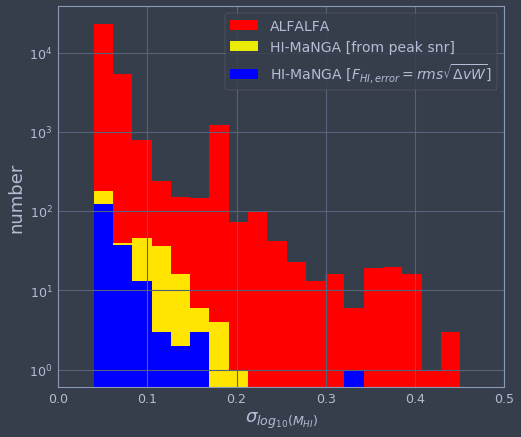

In [14]:
'''[TEST] the error of HI-MaNGA's HI mass'''
mgHI_err1 = np.power(((1/mgHI_snr)**2 + 0.1**2),0.5) / np.log(10)
# mgHI_err2 = np.power(((mgHI_rms-np.mean(mgHI_rms)) * np.power(10*1.2*mgHI_Wp20,0.5) / mgHI_flux)**2 + 0.1**2,0.5) / np.log(10)
mgHI_err2 = np.power((mgHI_rms*1e-3 * np.power(10*1.2*mgHI_Wp20,0.5) / mgHI_flux)**2 + 0.1**2,0.5) / np.log(10)

plt.figure(figsize=(8,7))
hist, bins, null = plt.hist(al_err,bins=50,color='red',label=r'ALFALFA')
# plt.hist(al_err,bins=10,color='orange',alpha=0.8,label='alfalfa')
plt.hist(mgHI_err1,bins=bins,color='yellow',alpha=0.9,label='HI-MaNGA [from peak snr]')

plt.ylabel("number")
plt.xlabel("HI mass error ($log_{10}$)")
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc="best",fontsize=14)
# plt.show()

# plt.figure(figsize=(6,5))
plt.hist(mgHI_err2,bins=bins, color='blue',label=r'HI-MaNGA [$F_{HI,error}=rms\sqrt{\Delta v W}$]')
plt.ylabel("number",fontsize=18)
plt.xlabel("$\sigma_{log_{10}(M_{HI})}$",fontsize=18)
plt.xlim(0,0.5)
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc="best",fontsize=14)
plt.show()

In [15]:
# MaNGA-HI 中的 sf 星系
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plateifu])
mgHI_sf_plateifu = mgHI_plateifu[chek==1]

# ALFALFA和MaNGA 匹配星系中的 sf 星系
mgal_plateifu = mg_alfa_fits[1].data['plateifu']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plateifu])
mgal_sf_plateifu = mgal_plateifu[chek==1]

In [16]:
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id]
    return math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
def _al_AGC(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    AGC = mg_alfa_fits[1].data['AGC'][tmp_id]
    return AGC
# def _HI_mass_err(plateifu):
#     if len(mgHI_sf_plateifu[plateifu==mgHI_sf_plateifu])==1:
#         #err = mgHI_err[mgHI_plateifu==plateifu][0]
#         err = -999
#     elif len(mgal_sf_plateifu[plateifu==mgal_sf_plateifu])==1:
#         err = al_err[_al_AGC(plateifu)==alfalfa_data['AGCNr'].values]
#     else:
#         err = -999
#     return err
def _mgal_HImass_err(plateifu):
    if len(mgal_sf_plateifu[plateifu==mgal_sf_plateifu])==1:
        err = al_err[_al_AGC(plateifu)==alfalfa_data['AGCNr'].values]
    else:
        err = -999
    return err
def _mgHI_HImass_err(plateifu):
    if len(mgHI_sf_plateifu[plateifu==mgHI_sf_plateifu])==1:
        err = mgHI_err[mgHI_plateifu==plateifu][0]
    else:
        err = -999
    return err
def _mgHI_mass(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    if len(mgHI_fits[1].data['plateifu'][tmp_id])==0:
        return -999
    HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mgHI_fits[1].data['logHIlim200kms'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
def _mgal_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    if len(mg_alfa_fits[1].data['plateifu'][tmp_id])==0:
        return -999
    HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mg_alfa_fits[1].data['LOGHILIM200KMS'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
def _HI_mass(plateifu):
    tmp_id1 = (plateifu==mgHI_sf_plateifu)
    tmp_id2 = (plateifu==mgal_sf_plateifu)
    #print(len(mgHI_sf_plateifu[tmp_id1]))
    #print(len(mgal_sf_plateifu[tmp_id2]))
    if len(mgHI_sf_plateifu[tmp_id1])==1:
        return _mgHI_mass(plateifu)
    elif len(mgal_sf_plateifu[tmp_id2])==1:
        return _mgal_mass(plateifu)
    else:
        return -999
    pass
def _alm_galaxy(plateifu):
    # ALM 判断条件
    cri = -0.133
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    dev_Z = manga_Z['metallicity_deviation'].values[tmp_id]
    sur_density = manga_Z['dep_surface_mass_density'].values[tmp_id]
    mass = manga_Z['stellar_mass_global'].values[tmp_id]
    num_spaxels = len(dev_Z[(dev_Z <= cri)&(sur_density>7)&(mass>9)])
    return num_spaxels
# 得到单个星系的 ALM数量，sf数量，ALM/sf比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm, num_sf, num_alm / num_sf
# 泊松误差
def _possion_err_spaxel(plateifu):
    alm_num,sf_num,almosf = _alm_o_sf_spaxels(plateifu)
    err = math.sqrt(alm_num)/sf_num
    return err
alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in sf_gal_plifu])
alm_number = np.array([_alm_o_sf_spaxels(plateifu)[0] for plateifu in sf_gal_plifu])
sf_number = np.array([_alm_o_sf_spaxels(plateifu)[1] for plateifu in sf_gal_plifu])
possion_err = np.array([_possion_err_spaxel(plateifu) for plateifu in sf_gal_plifu])
HI_mass_err = np.array([_mgal_HImass_err(plateifu) for plateifu in sf_gal_plifu])
HI_mass = np.array([_HI_mass(plateifu) for plateifu in sf_gal_plifu])
stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in sf_gal_plifu])

mgHI_alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in mgHI_sf_plateifu])
mgHI_alm_number = np.array([_alm_o_sf_spaxels(plateifu)[0] for plateifu in mgHI_sf_plateifu])
mgHI_sf_number = np.array([_alm_o_sf_spaxels(plateifu)[1] for plateifu in mgHI_sf_plateifu])
mgHI_possion_err = np.array([_possion_err_spaxel(plateifu) for plateifu in mgHI_sf_plateifu])
mgHI_HI_mass_err = np.array([_mgHI_HImass_err(plateifu) for plateifu in mgHI_sf_plateifu])
mgHI_HI_mass = np.array([_HI_mass(plateifu) for plateifu in mgHI_sf_plateifu])
mgHI_stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in mgHI_sf_plateifu])
# flat/flatten the array 
# HI_mass_err = np.concatenate(HI_mass_err).ravel()

In [17]:
print(HI_mass[HI_mass!=-999].shape)
print(HI_mass_err[HI_mass_err!=-999].shape)
print(alm_o_sf[alm_o_sf>=0].shape)
print(stellar_mass[stellar_mass>0].shape)

(536,)
(256,)
(1547,)
(1547,)


In [25]:
'''get rid of bad data [alfalfa]'''
tmp_id = copy((HI_mass_err!=-999)&(HI_mass!=-999)&(alm_number!=0))
HI_mass_err = HI_mass_err[tmp_id]
HI_mass = HI_mass[tmp_id]
stellar_mass = stellar_mass[tmp_id]
alm_o_sf = alm_o_sf[tmp_id]
alm_number = alm_number[tmp_id]
sf_number = sf_number[tmp_id]
possion_err = possion_err[tmp_id]

print(HI_mass[HI_mass!=-999].shape)
print(HI_mass_err[HI_mass_err!=-999].shape)
print(alm_o_sf[alm_o_sf>=0].shape)
print(stellar_mass[stellar_mass>0].shape)
print(possion_err[possion_err>=0].shape)

(157,)
(157,)
(157,)
(157,)
(157,)


In [26]:
'''get rid of bad data [HI-MaNGA]'''
tmp_id = copy((mgHI_HI_mass_err!=-999)&(mgHI_HI_mass!=-999)&(~np.isnan(mgHI_HI_mass_err))&(mgHI_alm_number!=0))
mgHI_HI_mass_err = mgHI_HI_mass_err[tmp_id]
mgHI_HI_mass = mgHI_HI_mass[tmp_id]
mgHI_stellar_mass = mgHI_stellar_mass[tmp_id]
mgHI_alm_o_sf = mgHI_alm_o_sf[tmp_id]
mgHI_alm_number = mgHI_alm_number[tmp_id]
mgHI_sf_number = mgHI_sf_number[tmp_id]
mgHI_possion_err = mgHI_possion_err[tmp_id]

print(mgHI_HI_mass[mgHI_HI_mass!=-999].shape)
print(mgHI_HI_mass_err[mgHI_HI_mass_err!=-999].shape)
print(mgHI_alm_o_sf[mgHI_alm_o_sf>=0].shape)
print(mgHI_stellar_mass[mgHI_stellar_mass>0].shape)
print(mgHI_possion_err[mgHI_possion_err>=0].shape)

(60,)
(60,)
(60,)
(60,)
(60,)


In [40]:
HI_mass_err = np.concatenate(HI_mass_err)

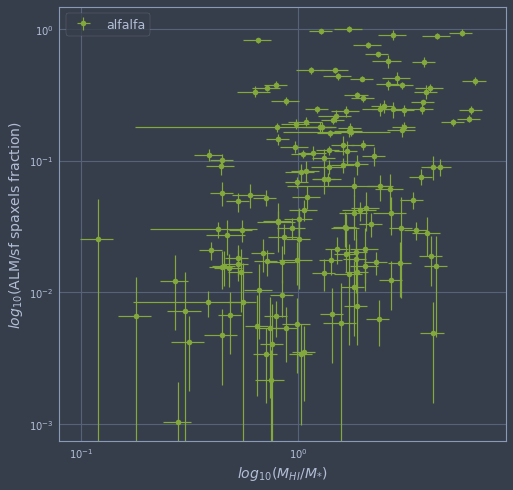

In [203]:
# variables prepared for plotting.
x = np.power(10,HI_mass-stellar_mass)
y = alm_o_sf
x_err = (np.power(10,HI_mass+HI_mass_err) - np.power(10,HI_mass)) / np.power(10,stellar_mass)
y_err = possion_err

# plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='g',label="alfalfa")#,fmt='o')
# x = np.power(10,mgHI_HI_mass-mgHI_stellar_mass)
# y = mgHI_alm_o_sf
# x_err = np.power(10,mgHI_HI_mass_err-mgHI_stellar_mass)
# y_err = mgHI_possion_err
# plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='orange',label="HI-MaNGA")#,fmt='o')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(np.power(10,tmp_xlim))
# plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$log_{10}(M_{HI}/M_{*})$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.legend(loc="best")
plt.show()

In [28]:
a = y
print("max is %f, min is %f" % (a.max(),a.min()))

max is 0.997487, min is 0.001044


In [30]:
from scipy import stats
# coeff = stats.pearsonr(np.log10(x), np.log10(y))
coeff = stats.spearmanr (np.log10(x), np.log10(y))

print("Correlation coefficient is ",coeff)

Correlation coefficient is  SpearmanrResult(correlation=0.41854115290316, pvalue=4.899237627211113e-08)


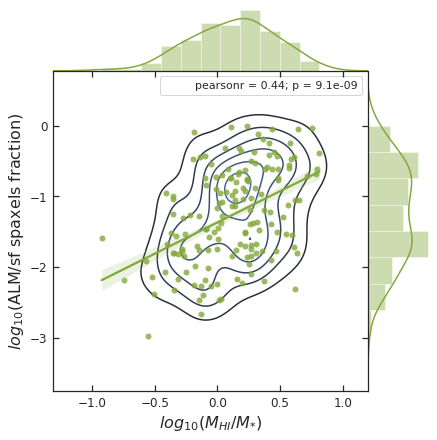

In [45]:
import seaborn as sns
# Plotting variable
# x = HI_mass - sf_stellar_mass
# y = np.log10(alm_o_sf)
# y_err = possion_err/alm_o_sf/np.log(10)
# x = np.power(10,HI_mass-sf_stellar_mass)
# y = alm_o_sf
# y_err = possion_err

# Plot!!!
# la = (sns.jointplot(x,y,space=0,kind="reg").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
sns.set(style="ticks", color_codes=False)
# la = (sns.JointGrid(x=x, y=y,space=0).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
# la= la.plot(sns.regplot,sns.distplot)

la = sns.jointplot(np.log10(x),np.log10(y),space=0,kind="reg", color='g',ci=68)

la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=6)
# la.plot_joint(sns.regplot,color='g', ci=68,label='68%')
# plt.errorbar(x,y,yerr=y_err,fmt='o')#,fmt='o')
# ax = sns.pointplot(x,y,dodge=True, join=False, ci=None)
# print(ax.collections)
# x_coords = []
# y_coords = []
# for point_pair in ax.collections:
#     for tmp_x, tmp_y in point_pair.get_offsets():
#         x_coords.append(tmp_x)
#         y_coords.append(tmp_y)
# ax.errorbar(x_coords, y_coords, yerr=y_err, fmt=' ', zorder=-1)

# label
la.set_axis_labels('$log_{10}(M_{HI}/M_{*})$', '$log_{10}$(ALM/sf spaxels fraction)', fontsize=16)#,fontweight='bold')  
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
# la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
# la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)
# la.annotate(stats.spearmanr)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tick_params(axis="x",direction="in",pad=3)
# plt.tick_params(axis="y",direction="in",pad=3)
plt.tick_params(which='both',direction='in')

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')

tmp_xlim = plt.xlim()
tmp_ylim = plt.ylim()

plt.show()

In [41]:
from scipy import stats
coeff = stats.pearsonr(np.log10(x), np.log10(y))
# coeff = stats.spearmanr (np.log10(x), np.log10(y))

print("Correlation coefficient is ",coeff)

Correlation coefficient is  (0.43864895373299023, 9.124384436118821e-09)


# Correlation coefficient error
+ 蒙特卡罗方法计算相关系数的误差
> y轴方向为 alm/sf spaxles，按照随机泊松分布来生成   
> x轴方向为 HI mass，按照随机正态分布来生成

In [157]:
from scipy import stats
from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('onedork')#('grade3')

In [204]:
'''generate random number'''

# according to the data and error we have
from scipy import asarray as ar,exp
from scipy.optimize import curve_fit
from scipy import stats
# 一般高斯函数
def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

x = np.power(10,HI_mass-stellar_mass)
y = alm_o_sf #alm_number #alm_o_sf
coeff = stats.pearsonr(np.log10(x), np.log10(y))
# coeff = stats.spearmanr(x_rand, y_rand)

print("original correlation coefficient is ", coeff)
# ****************************************************** #


# ****************************************************** #
x_err = np.concatenate(HI_mass_err)#HI_mass_err#np.power(10,HI_mass_err-stellar_mass)
x_err = np.power(10,HI_mass+x_err) - np.power(10,HI_mass)
x_err = np.concatenate([x_err,])
# y_err = possion_err

num_random = 60000
x = np.power(10,HI_mass)#-stellar_mass)
y = alm_number #alm_o_sf
# generate x random data [normal distribution]
x_rand = np.random.normal(x,x_err,(num_random,x.size))
x_rand = x_rand/np.power(10,stellar_mass)
# generate y random data [poisson distribution]
y_rand = np.random.poisson(y, (num_random,y.size))
y_rand = y_rand/sf_number

# compute the correlation coefficient
coeff = stats.spearmanr(np.log10(x_rand)[68,:], np.log10(y_rand)[68,:])
# coeff = stats.spearmanr(np.log10(x_rand)[68,:], np.log10(y_rand))

print("random correlation coefficient is ", coeff)

original correlation coefficient is  (0.43864895373299023, 9.124384436118821e-09)
random correlation coefficient is  SpearmanrResult(correlation=0.4042148742410365, pvalue=1.5199813856231935e-07)


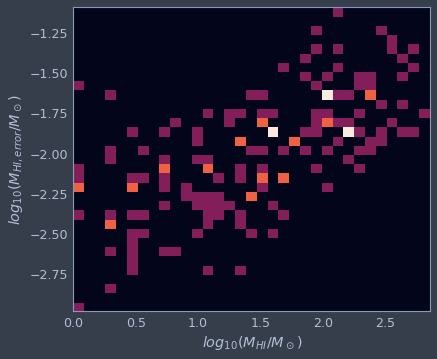

In [205]:
'''[test] the HI mass error'''
# plt.hist2d(np.log10(x),np.log10(x_err),bins=33)
plt.hist2d(np.log10(y),np.log10(y_err),bins=33)
# plt.xscale("log");plt.yscale("log")
plt.xlabel(r"$log_{10}(M_{HI}/M_\odot)$")
plt.ylabel(r"$log_{10}(M_{HI,error}/M_\odot)$")
plt.show()

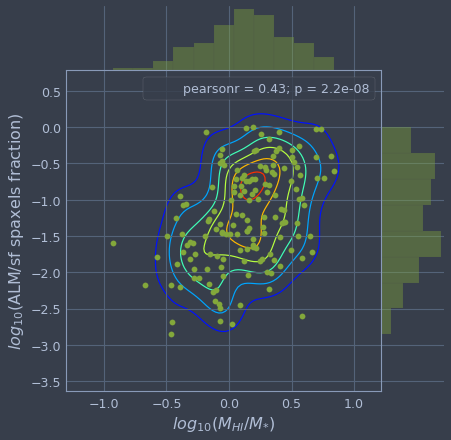

In [194]:
tmp_randx = x_rand[7,:]
tmp_randy = y_rand[7,:]
tmp_id = (tmp_randy!=0)
x = tmp_randx[tmp_id]
y = tmp_randy[tmp_id]

# 散点图
la = sns.jointplot(np.log10(x),np.log10(y),space=0,color='g')
# la = sns.jointplot(np.log10(x),np.log10(y),space=0,kind="reg", color='g',ci=68)

# 等高线图
la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=6,cmap="jet",linewidth=10)

# details
la.set_axis_labels('$log_{10}(M_{HI}/M_{*})$', '$log_{10}$(ALM/sf spaxels fraction)', fontsize=16)
la.annotate(stats.pearsonr)
plt.show()

the error of correlation coefficient is  [8.84647212e+03 3.97555331e-01 2.79965717e-02]


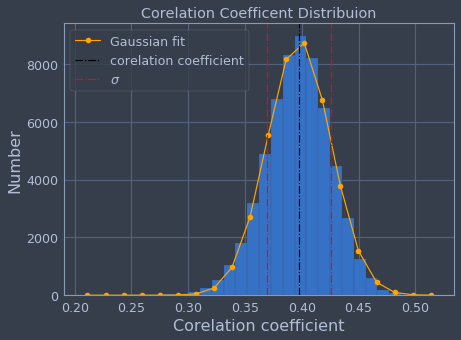

In [206]:
'''error of corellation coefficient'''
x = np.log10(x_rand)
y = np.log10(y_rand)

# calculate correlation coefficient per group
# coeff_rand = np.ones(num_random)*np.nan
# for i in range(num_random):
#     coeff_rand[i] = stats.spearmanr(x_rand[i,:], y_rand[i,:])[0]
#     #coeff_rand[i] = stats.pearsonr(x_rand, y_rand[i,:])
#     pass
def _coeff(x,y):
    tmp_id = (~np.isnan(x))&(~np.isinf(x))&(~np.isnan(y))&(~np.isinf(y))
    #if np.size(tmp_id[~tmp_id])!=0:return -999
    x = x[tmp_id]
    y = y[tmp_id]
    correlation_coeff = stats.pearsonr(x,y)[0]
    #correlation_coeff = stats.spearmanr(x,y)[0]
    return correlation_coeff
coeff_rand = np.array([_coeff(x[i,:],y[i,:]) for i in range(num_random)])
# coeff_rand = np.array([_coeff(x[i,:],y) for i in range(num_random)])
coeff_rand = coeff_rand[coeff_rand!=-999]
# view the distribution of coefficient
plt.figure(figsize=(7,5))
ycount, xbins, ignored = plt.hist(coeff_rand, 30)#, normed=True)


# calculate the error of coefficient
x = (xbins[:-1]+xbins[1:])/2
y = ycount
n = len(x)# 拟合数据长度
mean = sum(x)/n# 平均数
sigma = np.std(x)#(sum((x-mean)**2)/n)**0.5# 标准差
ymax = np.max(y)# y轴最大值，即拟合函数的幅度[高度]大小

popt0,pcov0 = curve_fit(gaus,x,y,p0=[ymax,mean,sigma])
newx0 = np.linspace(x.min(),x.max(),20)
print("the error of correlation coefficient is ", popt0)

plt.plot(newx0,gaus(newx0,*popt0),'o-',color='orange',label='Gaussian fit')

# ALM 标准
rand_coeff = popt0[1]
rand_sigma = popt0[2]
plt.axvline(rand_coeff,color='black',linestyle='-.',label='corelation coefficient')
plt.axvline(rand_coeff+rand_sigma,color='red',linestyle='-.',label='$\sigma$')
plt.axvline(rand_coeff-rand_sigma,color='red',linestyle='-.')
# plt.annotate(r'$\sigma$ = %.3f' % rand_sigma, xy=(rand_coeff+rand_sigma+0.03, 10), xycoords='data', xytext=(0,0),
#              textcoords='offset points', fontsize=11,
#              arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

plt.tick_params(which='both',direction='in')
plt.legend(loc='best')
plt.title("Corelation Coefficent Distribuion")
plt.xlabel('Corelation coefficient',fontsize=16)
plt.ylabel('Number',fontsize=16)
# plt.plot(newxx,newyy,'k--',label='Plus Gaussian fit')# 画图
plt.show()

## 将明显偏离的数据丢弃

# 按照 stellar mass 分组 

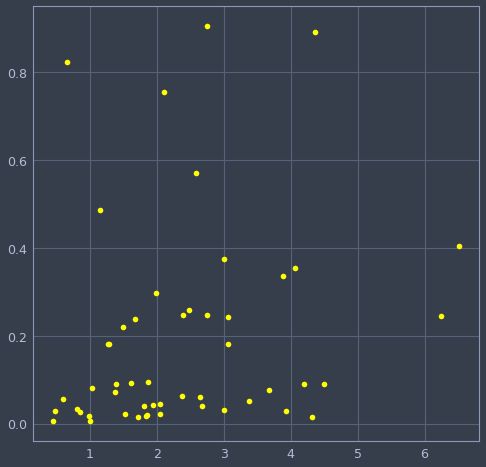

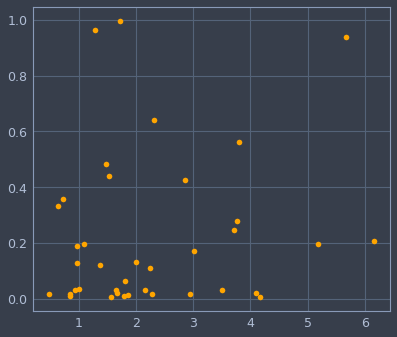

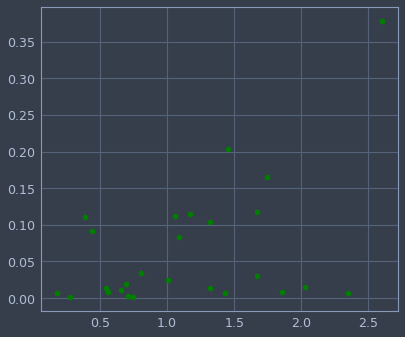

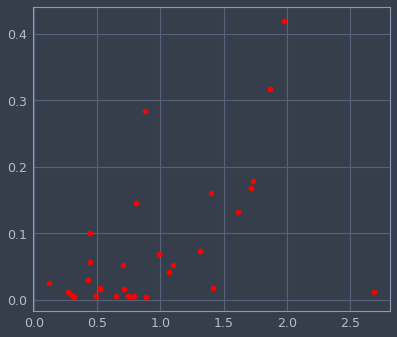

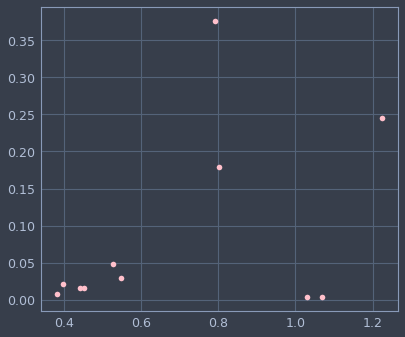

No handles with labels found to put in legend.


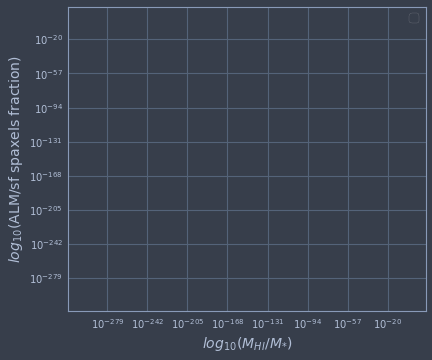

In [223]:


# variables prepared for plotting.
x = np.power(10,HI_mass-stellar_mass)
y = alm_o_sf
x_err = (np.power(10,HI_mass+HI_mass_err) - np.power(10,HI_mass)) / np.power(10,stellar_mass)
y_err = possion_err

# ******************************************************************* #
# 分组
num_bins = 5
colors_arr = ['yellow','orange','green','red','pink']
ycounts,xbins = np.histogram(stellar_mass,bins=num_bins)
xbins_max = xbins[1:]
xbins_min = xbins[:-1]
plt.figure(figsize=(8,8))
for i in range(num_bins):
    if i == (num_bins-1):
        tmp_id = (stellar_mass>=xbins_min[i])&(stellar_mass<=xbins_max[i])
    else:
        tmp_id = (stellar_mass>=xbins_min[i])&(stellar_mass<xbins_max[i])
    plt_x = x[tmp_id]
    plt_y = y[tmp_id]
    plt_xerr = x_err[tmp_id]
    plt_yerr = y_err[tmp_id]
    # plot!
    #plt.errorbar(plt_x,plt_y,xerr=plt_xerr,yerr=plt_yerr,fmt='o',color=colors_arr[i])#,label="alfalfa")
    plt.plot(plt_x,plt_y,'o',color=colors_arr[i],
             label="$M_{HI}: %.1f - %.1f$"%(xbins_min[i],xbins_max[i]))
    plt.show()
# ******************************************************************* #

# plot

# plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='g',label="alfalfa")#,fmt='o')
# x = np.power(10,mgHI_HI_mass-mgHI_stellar_mass)
# y = mgHI_alm_o_sf
# x_err = np.power(10,mgHI_HI_mass_err-mgHI_stellar_mass)
# y_err = mgHI_possion_err
# plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='orange',label="HI-MaNGA")#,fmt='o')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(np.power(10,tmp_xlim))
# plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$log_{10}(M_{HI}/M_{*})$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.legend(loc="best")
plt.show()

In [337]:
# 展开 HI mass error 数组
def _flat(T):
    if type(T) is not np.ndarray: return np.array(T)
    elif len(T) == 0: return np.array([])
    else: return _flat(T[0])+_flat(T[1:])
    pass
print(_flat(np.array([1,2,3,5,55])))
# print(np.array(_flat(a)))

[]


In [ ]:
bins=np.logspace(np.log10(np.min(lum)),np.log10(np.max(lum)), 300)  # log10 bins
ycount, xbins = np.histogram(lum,bins=bins)

lum_bins = (xbins[:-1]+xbins[1:])/2  # translation the coordinate

ycounts, bins, null = np.histogram(stellar_mass,bins=30)

# 展开任意形状维度的 tuple、list

In [60]:
'''flatten any kind of tuple'''
import numpy as np
a = (((1,2),3),(4,5),6,(),(((555,3))))
def _flat(T):
    if type(T) is not tuple: return (T,)
    elif len(T) == 0: return ()
    else: return _flat(T[0])+_flat(T[1:])
    pass
print(_flat(a))
print(np.array(_flat(a)))

(1, 2, 3, 4, 5, 6, 555, 3)
[  1   2   3   4   5   6 555   3]


In [1]:
'''[Python 2.7] flatten any kind of tuple'''
import types
def flatten(T):
    if type(T) != types.TupleType: return (T,)
    elif len(T)==0: return ()
    else: return flatten(T[0]) + flatten(T[1:])
a = (((1,2),3),(4,5),6,())
flatten(a)

(1, 2, 3, 4, 5, 6)